# Phishing Website Detection 

Step -1 : Data preprocessing 

This dataset contains few website links (Some of them are legitimate websites and a few are fake websites)

Pre-Processing the data before building a model and also Extracting the features from the data based on certain conditions

In [1]:
#importing numpy and pandas which are required for data pre-processing
import numpy as np
import pandas as pd
import pickle
import sklearn
#from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from PyQt5 import QtCore, QtGui, QtWidgets
from PyQt5.QtWidgets import QPushButton
import feature_extractor
import seaborn as sns
import matplotlib.pyplot as plt
import tkinter as tk
import tkinter.font as font
import warnings
warnings.filterwarnings("ignore")

In [2]:
df1=pd.read_csv('malicious_phish.csv')

In [3]:
df1.shape

(651191, 2)

In [4]:
df1.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [5]:
df2=pd.read_csv('phishing_site_urls.csv')

In [6]:
df2.shape

(549346, 2)

In [7]:
df2.head()

,URL,Label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad
3,mail.printakid.com/www.online.americanexpress....,bad
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad


In [8]:
df1.type.value_counts()

benign        428103
defacement     96457
phishing       94111
malware        32520
Name: type, dtype: int64

In [9]:
df1['type']=df1['type'].replace('defacement','benign')

In [10]:
df1['type']=df1['type'].replace('malware','phishing')

In [11]:
df1.type.value_counts()

benign      524560
phishing    126631
Name: type, dtype: int64

In [12]:
df2.Label.value_counts()

good    392924
bad     156422
Name: Label, dtype: int64

In [13]:
df1['type']=df1['type'].replace('benign','good')

In [14]:
df1['type']=df1['type'].replace('phishing','bad')

In [15]:
df2.rename(columns = {'URL':'url','Label':'type'}, inplace = True)

In [16]:
#Loading the data
raw_data = pd.concat([df1, df2], axis=0) 

In [17]:
raw_data.shape

(1200537, 2)

In [18]:
raw_data.columns

Index(['url', 'type'], dtype='object')

In [19]:
raw_data.head()

,url,type
0,br-icloud.com.br,bad
1,mp3raid.com/music/krizz_kaliko.html,good
2,bopsecrets.org/rexroth/cr/1.htm,good
3,http://www.garage-pirenne.be/index.php?option=...,good
4,http://adventure-nicaragua.net/index.php?optio...,good


In [20]:
raw_data.type.value_counts()

good    917484
bad     283053
Name: type, dtype: int64

In [21]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1200537 entries, 0 to 549345
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   url     1200537 non-null  object
 1   type    1200537 non-null  object
dtypes: object(2)
memory usage: 27.5+ MB


In [22]:
raw_data.isnull().sum()

url     0
type    0
dtype: int64

We need to split the data according to parts of the URL

A typical URL could have the form http://www.example.com/index.html, which indicates a protocol (http), a hostname (www.example.com), and a file name (index.html).

In [23]:
raw_data['url'].str.split("://").head() #Here we divided the protocol from the entire URL. but need it to be divided it 
                                                 #seperate column

0                                   [br-icloud.com.br]
1                [mp3raid.com/music/krizz_kaliko.html]
2                    [bopsecrets.org/rexroth/cr/1.htm]
3    [http, www.garage-pirenne.be/index.php?option=...
4    [http, adventure-nicaragua.net/index.php?optio...
Name: url, dtype: object

In [24]:
seperation_of_protocol = raw_data['url'].str.split("://",expand = True) #expand argument in the split method will give you a new column

In [25]:
seperation_of_protocol.head()

,0,1,2,3,4,5,6,7,8,9
0,br-icloud.com.br,None,None,None,None,None,None,None,None,None
1,mp3raid.com/music/krizz_kaliko.html,None,None,None,None,None,None,None,None,None
2,bopsecrets.org/rexroth/cr/1.htm,None,None,None,None,None,None,None,None,None
3,http,www.garage-pirenne.be/index.php?option=com_con...,None,None,None,None,None,None,None,None
4,http,adventure-nicaragua.net/index.php?option=com_m...,None,None,None,None,None,None,None,None


In [26]:
type(seperation_of_protocol)

pandas.core.frame.DataFrame

In [27]:
seperation_domain_name = seperation_of_protocol[1].str.split("/",1,expand = True) #split(seperator,no of splits according to seperator(delimiter),expand)

In [28]:
type(seperation_domain_name)

pandas.core.frame.DataFrame

In [29]:
seperation_domain_name.columns=["domain_name","address"] #renaming columns of data frame

In [30]:
seperation_domain_name.head()

,domain_name,address
0,None,None
1,None,None
2,None,None
3,www.garage-pirenne.be,index.php?option=com_content&view=article&id=7...
4,adventure-nicaragua.net,index.php?option=com_mailto&tmpl=component&lin...


In [31]:
#Concatenation of data frames
splitted_data = pd.concat([seperation_of_protocol[0],seperation_domain_name],axis=1)


In [32]:
splitted_data.columns = ['protocol','domain_name','address']

In [33]:
splitted_data.head()

,protocol,domain_name,address
0,br-icloud.com.br,None,None
1,mp3raid.com/music/krizz_kaliko.html,None,None
2,bopsecrets.org/rexroth/cr/1.htm,None,None
3,http,www.garage-pirenne.be,index.php?option=com_content&view=article&id=7...
4,http,adventure-nicaragua.net,index.php?option=com_mailto&tmpl=component&lin...


In [34]:
splitted_data['type'] = pd.Series(raw_data['type'], index=splitted_data.index)

In [35]:
splitted_data

,protocol,domain_name,address,type
0,br-icloud.com.br,None,None,bad
1,mp3raid.com/music/krizz_kaliko.html,None,None,good
2,bopsecrets.org/rexroth/cr/1.htm,None,None,good
3,http,www.garage-pirenne.be,index.php?option=com_content&view=article&id=7...,good
4,http,adventure-nicaragua.net,index.php?option=com_mailto&tmpl=component&lin...,good
...,...,...,...,...
549341,23.227.196.215/,None,None,bad
549342,apple-checker.org/,None,None,bad
549343,apple-iclods.org/,None,None,bad
549344,apple-uptoday.org/,None,None,bad


Domain name column can be further sub divided into domain_names as well as sub_domain_names 

Similarly, address column can also be further sub divided into path,query_string,file..................

In [36]:
type(splitted_data)

pandas.core.frame.DataFrame

### Features Extraction


Feature-1

1.Long URL to Hide the Suspicious Part

If the length of the URL is greater than or equal 54 characters then the URL classified as phishing


0 --- indicates legitimate

1 --- indicates Phishing

2 --- indicates Suspicious

In [37]:
def long_url(l):
    l= str(l)
    """This function is defined in order to differntiate website based on the length of the URL"""
    if len(l) < 54:
        return 0
    elif len(l) >= 54 and len(l) <= 75:
        return 2
    return 1

In [38]:
#Applying the above defined function in order to divide the websites into 3 categories
splitted_data['long_url'] = raw_data['url'].apply(long_url) 


In [39]:
#Will show the results only the websites which are legitimate according to above condition as 0 is legitimate website
splitted_data[splitted_data.long_url == 0] 

,protocol,domain_name,address,type,long_url
0,br-icloud.com.br,None,None,bad,0
1,mp3raid.com/music/krizz_kaliko.html,None,None,good,0
2,bopsecrets.org/rexroth/cr/1.htm,None,None,good,0
6,espn.go.com/nba/player/_/id/3457/brandon-rush,None,None,good,0
7,yourbittorrent.com/?q=anthony-hamilton-soulife,None,None,good,0
...,...,...,...,...,...
549341,23.227.196.215/,None,None,bad,0
549342,apple-checker.org/,None,None,bad,0
549343,apple-iclods.org/,None,None,bad,0
549344,apple-uptoday.org/,None,None,bad,0


Feature-2

2.URL’s having “@” Symbol

Using “@” symbol in the URL leads the browser to ignore everything preceding the “@” symbol and the real address often follows the “@” symbol.

IF {Url Having @ Symbol→ Phishing
    Otherwise→ Legitimate }


0 --- indicates legitimate

1 --- indicates Phishing


In [40]:
def have_at_symbol(l):
    """This function is used to check whether the URL contains @ symbol or not"""
    if "@" in str(l):
        return 1
    return 0
    

In [41]:
splitted_data['having_@_symbol'] = raw_data['url'].apply(have_at_symbol)

In [42]:
splitted_data

,protocol,domain_name,address,type,long_url,having_@_symbol
0,br-icloud.com.br,None,None,bad,0,0
1,mp3raid.com/music/krizz_kaliko.html,None,None,good,0,0
2,bopsecrets.org/rexroth/cr/1.htm,None,None,good,0,0
3,http,www.garage-pirenne.be,index.php?option=com_content&view=article&id=7...,good,1,0
4,http,adventure-nicaragua.net,index.php?option=com_mailto&tmpl=component&lin...,good,1,0
...,...,...,...,...,...,...
549341,23.227.196.215/,None,None,bad,0,0
549342,apple-checker.org/,None,None,bad,0,0
549343,apple-iclods.org/,None,None,bad,0,0
549344,apple-uptoday.org/,None,None,bad,0,0


Feature-3

3.Redirecting using “//”

The existence of “//” within the URL path means that the user will be redirected to another website.
An example of such URL’s is: “http://www.legitimate.com//http://www.phishing.com”. 
We examine the location where the “//” appears. 
We find that if the URL starts with “HTTP”, that means the “//” should appear in the sixth position. 
However, if the URL employs “HTTPS” then the “//” should appear in seventh position.

IF {ThePosition of the Last Occurrence of "//" in the URL > 7→ Phishing
    
    Otherwise→ Legitimate

0 --- indicates legitimate

1 --- indicates Phishing


In [43]:
def redirection(l):
    """If the url has symbol(//) after protocol then such URL is to be classified as phishing """
    if "//" in str(l):
        return 1
    return 0

In [44]:
splitted_data['redirection_//_symbol'] = seperation_of_protocol[1].apply(redirection)

In [45]:
splitted_data.head()

,protocol,domain_name,address,type,long_url,having_@_symbol,redirection_//_symbol
0,br-icloud.com.br,None,None,bad,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,None,None,good,0,0,0
2,bopsecrets.org/rexroth/cr/1.htm,None,None,good,0,0,0
3,http,www.garage-pirenne.be,index.php?option=com_content&view=article&id=7...,good,1,0,0
4,http,adventure-nicaragua.net,index.php?option=com_mailto&tmpl=component&lin...,good,1,0,0


Feature-4

4.Adding Prefix or Suffix Separated by (-) to the Domain

The dash symbol is rarely used in legitimate URLs. Phishers tend to add prefixes or suffixes separated by (-) to the domain name
so that users feel that they are dealing with a legitimate webpage. 

For example http://www.Confirme-paypal.com/.
    
IF {Domain Name Part Includes (−) Symbol → Phishing
    
    Otherwise → Legitimate
    
1 --> indicates phishing

0 --> indicates legitimate
    

In [46]:
def prefix_suffix_seperation(l):
    if '-' in str(l):
        return 1
    return 0

In [47]:
splitted_data['prefix_suffix_seperation'] = seperation_domain_name['domain_name'].apply(prefix_suffix_seperation)

In [48]:
splitted_data.head()

,protocol,domain_name,address,type,long_url,having_@_symbol,redirection_//_symbol,prefix_suffix_seperation
0,br-icloud.com.br,None,None,bad,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,None,None,good,0,0,0,0
2,bopsecrets.org/rexroth/cr/1.htm,None,None,good,0,0,0,0
3,http,www.garage-pirenne.be,index.php?option=com_content&view=article&id=7...,good,1,0,0,1
4,http,adventure-nicaragua.net,index.php?option=com_mailto&tmpl=component&lin...,good,1,0,0,1


Feature - 5

5. Sub-Domain and Multi Sub-Domains

The legitimate URL link has two dots in the URL since we can ignore typing “www.”. 
If the number of dots is equal to three then the URL is classified as “Suspicious” since it has one sub-domain.
However, if the dots are greater than three it is classified as “Phishy” since it will have multiple sub-domains

0 --- indicates legitimate

1 --- indicates Phishing

2 --- indicates Suspicious


In [49]:
def sub_domains(l):
    l= str(l)
    if l.count('.') < 3:
        return 0
    elif l.count('.') == 3:
        return 2
    return 1

In [50]:
splitted_data['sub_domains'] = splitted_data['domain_name'].apply(sub_domains)

In [51]:
splitted_data

,protocol,domain_name,address,type,long_url,having_@_symbol,redirection_//_symbol,prefix_suffix_seperation,sub_domains
0,br-icloud.com.br,None,None,bad,0,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,None,None,good,0,0,0,0,0
2,bopsecrets.org/rexroth/cr/1.htm,None,None,good,0,0,0,0,0
3,http,www.garage-pirenne.be,index.php?option=com_content&view=article&id=7...,good,1,0,0,1,0
4,http,adventure-nicaragua.net,index.php?option=com_mailto&tmpl=component&lin...,good,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...
549341,23.227.196.215/,None,None,bad,0,0,0,0,0
549342,apple-checker.org/,None,None,bad,0,0,0,0,0
549343,apple-iclods.org/,None,None,bad,0,0,0,0,0
549344,apple-uptoday.org/,None,None,bad,0,0,0,0,0


In [52]:
splitted_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1200537 entries, 0 to 549345
Data columns (total 9 columns):
 #   Column                    Non-Null Count    Dtype 
---  ------                    --------------    ----- 
 0   protocol                  1200537 non-null  object
 1   domain_name               189092 non-null   object
 2   address                   188474 non-null   object
 3   type                      1200537 non-null  object
 4   long_url                  1200537 non-null  int64 
 5   having_@_symbol           1200537 non-null  int64 
 6   redirection_//_symbol     1200537 non-null  int64 
 7   prefix_suffix_seperation  1200537 non-null  int64 
 8   sub_domains               1200537 non-null  int64 
dtypes: int64(5), object(4)
memory usage: 91.6+ MB


<AxesSubplot:xlabel='type', ylabel='count'>

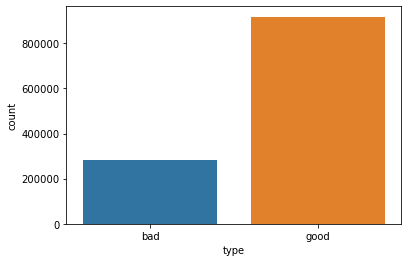

In [53]:
sns.countplot(splitted_data['type'])

<AxesSubplot:xlabel='long_url', ylabel='Density'>

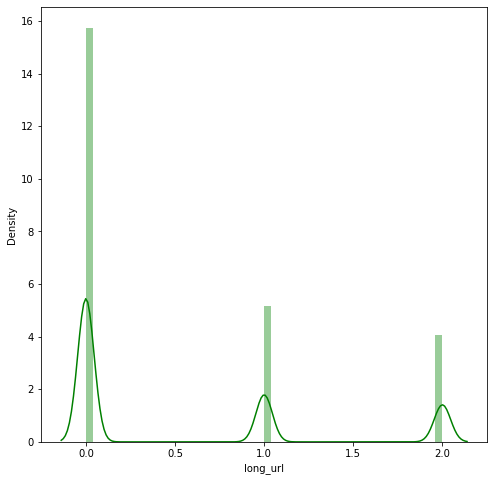

In [54]:
fig,ax=plt.subplots(figsize=(8,8))
sns.distplot(splitted_data.long_url,color='green')

In [55]:
#grids=sns.PairGrid(splitted_data)
#grids.map(plt.scatter)

In [56]:
#report=ProfileReport(splitted_data,title="Pandas Profiling Report")
#report

In [57]:
splitted_data.head()

,protocol,domain_name,address,type,long_url,having_@_symbol,redirection_//_symbol,prefix_suffix_seperation,sub_domains
0,br-icloud.com.br,None,None,bad,0,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,None,None,good,0,0,0,0,0
2,bopsecrets.org/rexroth/cr/1.htm,None,None,good,0,0,0,0,0
3,http,www.garage-pirenne.be,index.php?option=com_content&view=article&id=7...,good,1,0,0,1,0
4,http,adventure-nicaragua.net,index.php?option=com_mailto&tmpl=component&lin...,good,1,0,0,1,0


In [58]:
splitted_data.type.value_counts()

good    917484
bad     283053
Name: type, dtype: int64

In [59]:
splitted_data.replace({'type':{'good':1,'bad':0}},inplace=True)

In [60]:
splitted_data.type.value_counts()

1    917484
0    283053
Name: type, dtype: int64

In [61]:
splitted_data.describe()

,type,long_url,having_@_symbol,redirection_//_symbol,prefix_suffix_seperation,sub_domains
count,1.200537e+06,1.200537e+06,1.200537e+06,1.200537e+06,1.200537e+06,1.200537e+06
mean,7.642280e-01,5.332230e-01,2.827901e-03,2.224005e-04,2.260322e-02,4.941622e-02
std,4.244805e-01,7.583847e-01,5.310279e-02,1.491145e-02,1.486349e-01,3.075544e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,1.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00


In [62]:
splitted_data.corr()

,type,long_url,having_@_symbol,redirection_//_symbol,prefix_suffix_seperation,sub_domains
type,1.000000,0.061697,-0.064245,-0.025931,-0.024716,-0.110773
long_url,0.061697,1.000000,0.042643,0.006307,0.078938,0.016849
having_@_symbol,-0.064245,0.042643,1.000000,0.016037,0.001716,-0.001671
redirection_//_symbol,-0.025931,0.006307,0.016037,1.000000,0.005624,0.019036
prefix_suffix_seperation,-0.024716,0.078938,0.001716,0.005624,1.000000,0.053754
sub_domains,-0.110773,0.016849,-0.001671,0.019036,0.053754,1.000000


<AxesSubplot:>

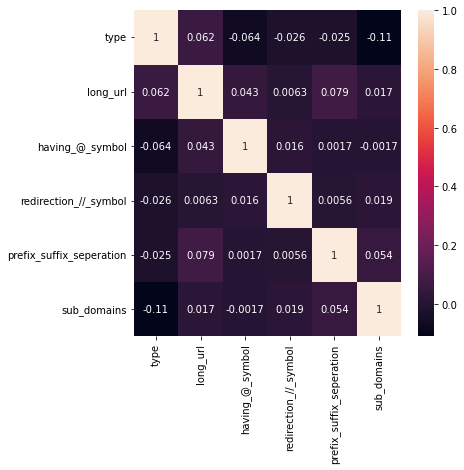

In [63]:
plt.figure(figsize=(6,6))
sns.heatmap(splitted_data.corr(),annot=True)

### Classification of URLs using Random forest 

In [64]:
#Features
x = splitted_data.loc[:,['long_url', 'having_@_symbol', 'redirection_//_symbol','prefix_suffix_seperation', 'sub_domains']]
x   

,long_url,having_@_symbol,redirection_//_symbol,prefix_suffix_seperation,sub_domains
0,0,0,0,0,0
1,0,0,0,0,0
2,0,0,0,0,0
3,1,0,0,1,0
4,1,0,0,1,0
...,...,...,...,...,...
549341,0,0,0,0,0
549342,0,0,0,0,0
549343,0,0,0,0,0
549344,0,0,0,0,0


In [65]:
#variable to be predicted; yes = 0 and no = 1
y = splitted_data.loc[:,['type']]
y 

,type
0,0
1,1
2,1
3,1
4,1
...,...
549341,0
549342,0
549343,0
549344,0


In [66]:
x.shape

(1200537, 5)

In [67]:
y.shape

(1200537, 1)

In [68]:
xtr,xte,ytr,yte=train_test_split(x,y,test_size=0.3,random_state=442)

In [69]:
# Create a random forest Classifier. By convention, clf means 'Classifier'
clf = RandomForestClassifier(n_estimators=100,n_jobs=2,random_state=0)
clf.fit(xtr,ytr)
ypred=clf.predict(xte)
RandomForestClassifier=accuracy_score(yte,ypred)*100
print("Accuracy of the model is ",RandomForestClassifier)


Accuracy of the model is  77.39517217252236


In [70]:
model=MultinomialNB()
model.fit(xtr,ytr)
ypred=model.predict(xte)
Multinomial=accuracy_score(yte,ypred)*100
print("Accuracy of the model is ",Multinomial)

Accuracy of the model is  76.6371799356956


In [71]:
dt = DecisionTreeClassifier()
dt.fit(xtr,ytr)
ypred=dt.predict(xte)
DecisionTreeClassifier=accuracy_score(yte,ypred)*100
print("Accuracy of the model is ",DecisionTreeClassifier)

Accuracy of the model is  77.39517217252236


In [72]:
lg = LogisticRegression()
lg.fit(xtr,ytr)
ypred=lg.predict(xte)
LogisticRegression=accuracy_score(yte,ypred)*100
print("Accuracy of the model is ",LogisticRegression)

Accuracy of the model is  76.67466306828594


In [73]:
#cv_score=cross_val_score(lg,x,y,cv=5)
#print("Cross Validation of the model is ",cv_score)

In [74]:
#mean_accuracy=sum(cv_score)/len(cv_score)
#mean_accuracy=mean_accuracy*100
#mean_accuracy=round(mean_accuracy,2)
#print("Mean Accuracy of the model is ",mean_accuracy)

In [75]:
df={'long_url':1,
    'having_@_symbol':0,
    'redirection_//_symbol':0,
    'prefix_suffix_seperation':1,
    'sub_domains':0}

In [76]:
df1=pd.DataFrame(df,index=[0])

In [77]:
df1

,long_url,having_@_symbol,redirection_//_symbol,prefix_suffix_seperation,sub_domains
0,1,0,0,1,0


In [78]:
dt.predict(df1)

array([1], dtype=int64)

In [79]:
filename = 'finalized_model.sav'
pickle.dump(clf, open(filename, 'wb'))

In [80]:
with open(filename,'rb') as file:
    score=pickle.load(file)

In [81]:
def predictor(splitted_data):
    print("/n script rf_model")
    # load the model from disk
    filename = 'finalized_model.sav'
    loaded_model = pickle.load(open(filename, 'rb'))
    print("model loaded")
    print(splitted_data.shape)
    print(list(splitted_data))
    x = splitted_data.columns[3:9]
    preds = loaded_model.predict(splitted_data[x])
    print("prediction complete")
    print(preds)
    if preds == 0:
        str1 = "Spoofed webpage: Yes"
    else: str1 = "Spoofed webpage: NO"
    
    score = loaded_model.predict_proba(splitted_data[x])
    str2 = "Confidence score: "+ str(score[0][1])

    return str1,str2

In [ ]:
class Ui_Spam_detector(object):
    def setupUi(self, Spam_detector):
        Spam_detector.setObjectName("Spam_detector")
        Spam_detector.resize(521, 389)
        self.centralwidget = QtWidgets.QWidget(Spam_detector)
        self.centralwidget.setObjectName("centralwidget")

        """check button code and its connectivity to button_click function"""
        self.check_button = QtWidgets.QPushButton(self.centralwidget)
        self.check_button.setGeometry(QtCore.QRect(210, 170, 93, 28))
        self.check_button.setObjectName("check_button")
        self.check_button.clicked.connect(self.button_click)

        """url input section"""
        self.url_input = QtWidgets.QLineEdit(self.centralwidget)
        self.url_input.setGeometry(QtCore.QRect(70, 111, 431, 31))
        self.url_input.setObjectName("url_input")
        
        self.label = QtWidgets.QLabel(self.centralwidget)
        self.label.setGeometry(QtCore.QRect(20, 110, 81, 31))
        self.label.setObjectName("label")
        
        button = QPushButton("Reset", self.centralwidget)
        button.setGeometry(210, 200, 93, 28)
        button.pressed.connect(self.do_something)
        
        """output message"""
        self.output_text = QtWidgets.QTextEdit(self.centralwidget)
        self.output_text.setGeometry(QtCore.QRect(30, 241, 461, 121))
        self.output_text.setObjectName("output_text")
        
        self.label_2 = QtWidgets.QLabel(self.centralwidget)
        self.label_2.setGeometry(QtCore.QRect(110, 10, 311, 41))
        self.label_2.setObjectName("label_2")
        
        Spam_detector.setCentralWidget(self.centralwidget)
        self.statusbar = QtWidgets.QStatusBar(Spam_detector)
        self.statusbar.setObjectName("statusbar")
        Spam_detector.setStatusBar(self.statusbar)

        self.retranslateUi(Spam_detector)
        QtCore.QMetaObject.connectSlotsByName(Spam_detector)

    def retranslateUi(self, Spam_detector):
        _translate = QtCore.QCoreApplication.translate
        Spam_detector.setWindowTitle(_translate("Spam_detector", "MainWindow"))
        self.check_button.setText(_translate("Spam_detector", "Check "))
        self.label.setText(_translate("Spam_detector", "<html><head/><body><p><span style=\" font-size:10pt;\">URL :</span></p></body></html>"))
        self.label_2.setText(_translate("Spam_detector", "<html><head/><body><p align=\"center\"><span style=\" font-size:16pt;\">Spam URL Detector</span></p></body></html>"))

    def button_click(self):
        text = self.url_input.text()
        #print(text)
        obj = feature_extractor.feature_extractor(text)
        str1,str2 = obj.extract()

        self.output_text.append("{} \n{}\n\n".format(str1,str2))
        
    def do_something(self):
  
        # clearing the spin box
        self.url_input.clear()
        self.output_text.clear()
        

    #def show_output():

if __name__ == "__main__":
    import sys
    app = QtWidgets.QApplication(sys.argv)
    Spam_detector = QtWidgets.QMainWindow()
    ui = Ui_Spam_detector()
    ui.setupUi(Spam_detector)
    Spam_detector.show()
    sys.exit(app.exec_())
